# Lag in reporting of Coronavirus Deaths in England - some data.

The BBC has an [article](https://www.bbc.co.uk/news/health-52167016) "Warning over daily death figures", noting "Experts are warning against over-interpreting daily figures of people dying with Covid-19, since they often reflect reporting delays.
Spikes or dips may in part reflect bottlenecks in the reporting system, rather than real changes in the trend."

The data for England is available as a series of spreadsheets at https://www.england.nhs.uk/statistics/statistical-work-areas/covid-19-daily-deaths/ . We can use this to investigate this issue, and help us understand the risk in thinking of the figures as "today's deaths" - which they are not.

This post is written using an approach to data analytics where the whole analysis script is made available, here as a [Jupyter Notebook](https://jupyter.org),
so that the work can be scrutinised and errors found quickly. Please follow along.

## Part one - obtain the data

In [2]:
import datetime, pandas, dateutil

The data is available from the second of April to the present day - let's get this series of days as a python list.

In [35]:
first_date = datetime.date(2020,4,2)

In [36]:
last_date = datetime.date.today()

In [37]:
def dates(date, last_date):
   while date <= last_date:
        yield date
        date += datetime.timedelta(days=1)
   return

In [38]:
list(dates(first_date, last_date))

[datetime.date(2020, 4, 2),
 datetime.date(2020, 4, 3),
 datetime.date(2020, 4, 4),
 datetime.date(2020, 4, 5),
 datetime.date(2020, 4, 6),
 datetime.date(2020, 4, 7),
 datetime.date(2020, 4, 8)]

The URLs to download from are constructed with a certain pattern which depends on the date. Thankfully, a nice and stable pattern.

In [39]:
def format_download(date):
    prefix = "https://www.england.nhs.uk/statistics/wp-content/uploads/sites/2/2020/"
    
    month = date.strftime("%m")
    monthname = date.strftime("%B")
    day_figure = str(int(date.strftime("%d")))
    date_dependent_part = f"{month}/COVID-19-daily-announced-deaths-{day_figure}-{monthname}-2020.xlsx"
    return prefix+date_dependent_part

In [42]:
download_strings = map(format_download, dates(first_date, last_date))
list(download_strings)

['https://www.england.nhs.uk/statistics/wp-content/uploads/sites/2/2020/04/COVID-19-daily-announced-deaths-2-April-2020.xlsx',
 'https://www.england.nhs.uk/statistics/wp-content/uploads/sites/2/2020/04/COVID-19-daily-announced-deaths-3-April-2020.xlsx',
 'https://www.england.nhs.uk/statistics/wp-content/uploads/sites/2/2020/04/COVID-19-daily-announced-deaths-4-April-2020.xlsx',
 'https://www.england.nhs.uk/statistics/wp-content/uploads/sites/2/2020/04/COVID-19-daily-announced-deaths-5-April-2020.xlsx',
 'https://www.england.nhs.uk/statistics/wp-content/uploads/sites/2/2020/04/COVID-19-daily-announced-deaths-6-April-2020.xlsx',
 'https://www.england.nhs.uk/statistics/wp-content/uploads/sites/2/2020/04/COVID-19-daily-announced-deaths-7-April-2020.xlsx',
 'https://www.england.nhs.uk/statistics/wp-content/uploads/sites/2/2020/04/COVID-19-daily-announced-deaths-8-April-2020.xlsx']

## Part two - clean the data

As expected, the spreadsheets are not quite consistently arranged across all the copies. 
Incidentally, its quite proper that the burden of data wrangling should fall on the data science community at this time.
While in the long run, I'd love it if we were all better at consitent reporting of national data over clean APIs,
now is not the time to add burdens to the NHS!

So, we need to convert the data into a consistent format.

In [48]:
def stabilise_date_datatype(content):
    try:
        return dateutil.parser.parse(content)
    except TypeError:
        return content

In [49]:
def url_to_dataframe(url):
    import urllib
    try:
        raw = pandas.read_excel(url,sheet_name = "COVID19 daily deaths by region")
    except urllib.error.HTTPError:
        return None
    dates_row = raw.index[raw['Unnamed: 1'].str.contains('NHS England').fillna(False)][0]
    dataframe = pandas.read_excel(url, header = dates_row + 1,index_col = 1, 
            sheet_name = "COVID19 daily deaths by region")
    return (dataframe.select_dtypes(include = ['object'])[dataframe.index.notnull()].
        fillna(0).rename(stabilise_date_datatype, axis='columns'))

In [50]:
dates_list = list(dates(first_date, last_date))
yesterday = dates_list[-2]

In [51]:
url_to_dataframe(format_download(first_date))

2020-03-01  2020-03-15  2020-03-16  2020-03-17  \
NHS England Region                                                         
England                            1           1           1           1   
East Of England                    0           0           0           0   
London                             0           0           0           0   
Midlands                           1           0           1           0   
North East And Yorkshire           0           0           0           0   
North West                         0           0           0           0   
South East                         0           1           0           1   
South West                         0           0           0           0   

                          2020-03-18  2020-03-19  2020-03-20  2020-03-21  \
NHS England Region                                                         
England                            3           1           2           6   
East Of England                    0           0           0           2   
London                             2           0           0           1   
Midlands                           1           0           0           1   
North East And Yorkshire           0           0           0           1   
North West                         0           1           1           1   
South East                         0           0           0           0   
South West                         0           0           1           0   

                          2020-03-22  2020-03-23  2020-03-24  2020-03-25  \
NHS England Region                                                         
England                           17           4           6          23   
East Of England                    0           0           0           4   
London                             7           1           2          11   
Midlands                           2           2           2           5   
North East And Yorkshire           0           0           0           0   
North West                         6           0           0           0   
South East                         2           1           2           3   
South West                         0           0           0           0   

                          2020-03-26  2020-03-27  2020-03-28  2020-03-29  \
NHS England Region                                                         
England                           29          25          24         130   
East Of England                    7           4           2          12   
London                            11           5           9          31   
Midlands                           5           7           6          26   
North East And Yorkshire           1           3           3          25   
North West                         2           3           3          18   
South East                         3           3           1          18   
South West                         0           0           0           0   

                          2020-03-30  2020-03-31  2020-04-01  
NHS England Region                                            
England                          159          44          84  
East Of England                   14           4           8  
London                            54          13          15  
Midlands                          30           8           8  
North East And Yorkshire          25          10          28  
North West                        15           4          14  
South East                        14           3           8  
South West                         7           2           3

In [52]:
frames = pandas.concat(dict(map(lambda date:  [date, url_to_dataframe(format_download(date))], 
                                dates_list[:-1]))).fillna(0)

In [53]:
england = frames.xs('England',level=1)
england

2020-03-01  2020-03-03  2020-03-09  2020-03-11  2020-03-15  \
2020-04-02         1.0         0.0         0.0         0.0         1.0   
2020-04-03         0.0         0.0         1.0         0.0         0.0   
2020-04-04         0.0         1.0         0.0         0.0         0.0   
2020-04-05         0.0         0.0         0.0         0.0         0.0   
2020-04-06         0.0         0.0         0.0         1.0         0.0   
2020-04-07         0.0         0.0         0.0         0.0         0.0   

            2020-03-16  2020-03-17  2020-03-18  2020-03-19  2020-03-20  ...  \
2020-04-02         1.0         1.0         3.0         1.0           2  ...   
2020-04-03         2.0         0.0         0.0         1.0           3  ...   
2020-04-04         1.0         0.0         1.0         0.0           5  ...   
2020-04-05         0.0         0.0         0.0         0.0           1  ...   
2020-04-06         0.0         0.0         0.0         1.0           3  ...   
2020-04-07         0.0         0.0         0.0         1.0           1  ...   

            2020-03-28  2020-03-29  2020-03-30  2020-03-31  2020-04-01  \
2020-04-02          24         130         159          44          84   
2020-04-03          29          62         102          59         179   
2020-04-04          17          57          46          26         134   
2020-04-05           7          25          29          19          51   
2020-04-06           2           5           7           5          14   
2020-04-07           1           6           9          22          33   

            2020-04-02  2020-04-03  2020-04-04  2020-04-05  2020-04-06  
2020-04-02         0.0         0.0         0.0         0.0         0.0  
2020-04-03        87.0         0.0         0.0         0.0         0.0  
2020-04-04       199.0        99.0         0.0         0.0         0.0  
2020-04-05       114.0       181.0        97.0         0.0         0.0  
2020-04-06        25.0        70.0       188.0        69.0         0.0  
2020-04-07        37.0        90.0       179.0       272.0        81.0  

[6 rows x 27 columns]

## Part three - analyse the data

We've seen that each day, deaths are reported which happened up to several days ago. Hence, the importance of not viewing the reports each day as "today's deaths". This is clearer with a plot:

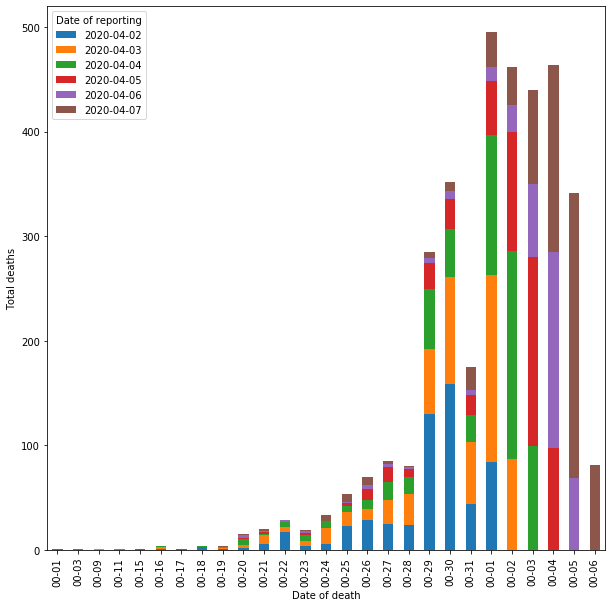

In [78]:
import matplotlib

axes = england.transpose().plot(kind='bar', stacked=True, figsize = [10,10])
axes.set_xlabel("Date of death")
axes.set_ylabel("Total deaths")
axes.legend().set_title("Date of reporting")
axes.set_xticklabels(map(lambda x: x.strftime("%M-%d"), england.columns));

The next step would be to investigate to what extent this data supports the hypothesis of increased reporting lag at weekends.

However, from the figure it is already clear that the lag in reporting is signficant. Co